# Sweetgreen Regional Analysis
Analyze restaurant data with a computed regional dimension

# Business Question
* Why is the distribution of outposts to restaurants non uniform?
* How is the decision to open new restaurants or outposts made?
* How is it decided which regions are good for new markets?

# Notes
* Bay Area region only has one outpost, which seems strange given the number of startups in the area

In [1]:
import sweetgreen as sg
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
restaurants = sg.utils.read_json("../data/cleaned/flattened_restaurants.json")
restaurants_df = pd.DataFrame(restaurants)

clusters = sg.cluster.location_clustering(restaurants_df)

restaurants_df["region"] = clusters
restaurants_df["region"] = restaurants_df["region"].replace(sg.cluster.CLUSTER_MAP)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, "display.width", 100):
    print(restaurants_df[["region", "address", "city", "state", "restaurant_slug"]].groupby("region").head(3).sort_values("region"))

         region                  address           city state         restaurant_slug
55     Bay Area               171 2nd St  San Francisco    CA                    soma
44     Bay Area            581 Ramona St      Palo Alto    CA               palo-alto
41     Bay Area        1890 Shattuck Ave       Berkeley    CA                berkeley
15       Boston          659 Boylston St         Boston    MA                back-bay
18       Boston          372 Congress St         Boston    MA              fort-point
21       Boston          210 Boylston St  Chestnut Hill    MA           chestnut-hill
77      Chicago         1000 Randolph St        Chicago    IL           fulton-market
50      Chicago           623 N State St        Chicago    IL             river-north
68      Chicago          1 N Dearborn St        Chicago    IL        dearborn-madison
0    DC, MD, VA  1512 Connecticut Ave NW     Washington    DC                  dupont
2    DC, MD, VA  221 Pennsylvania Ave SE     Washingto

# Count Number of Restaurants and Outposts in each region
Exclude hidden restaurants as many of them look like test locations

In [3]:
region_count = restaurants_df.loc[~restaurants_df["hidden"], ["region", "is_outpost", "restaurant_slug"]].groupby(["region", "is_outpost"]).count()
region_count = region_count.reset_index(1)
region_count["is_outpost"]= region_count["is_outpost"].replace({True:"Outpost", False:"Restaurant"})
region_count.columns = ["LocationType", "Count"]

region_count.head()

,LocationType,Count
region,,
Bay Area,Restaurant,6
Bay Area,Outpost,1
Boston,Restaurant,15
Boston,Outpost,9
Chicago,Restaurant,4


In [4]:
region_count_pivot = region_count.pivot(columns = "LocationType", values = ["Count"])
region_count_pivot.columns = region_count_pivot.columns.droplevel()
region_count_pivot

LocationType,Outpost,Restaurant
region,,
Bay Area,1,6
Boston,9,15
Chicago,9,4
"DC, MD, VA",10,26
Los Angeles,27,11
New York,37,22
Philly,3,6


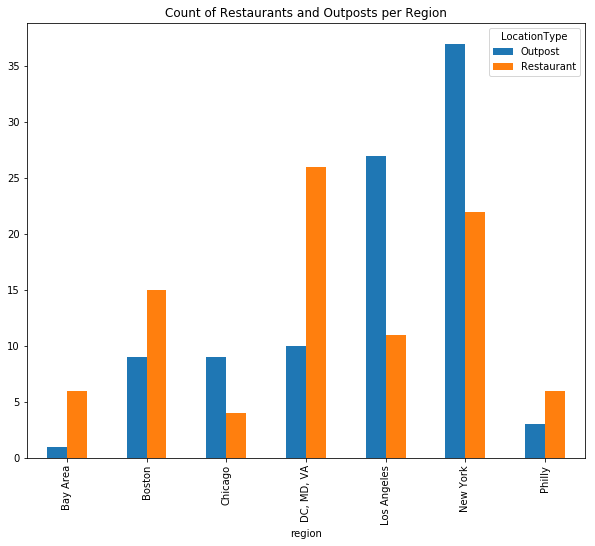

In [5]:
region_count_pivot.plot(kind="bar", figsize = (10,8), title="Count of Restaurants and Outposts per Region")

In [6]:
region_count_pivot.columns

Index(['Outpost', 'Restaurant'], dtype='object', name='LocationType')

Text(0.5, 0.98, 'Outpost Count normalized by Restaurant Count per region')

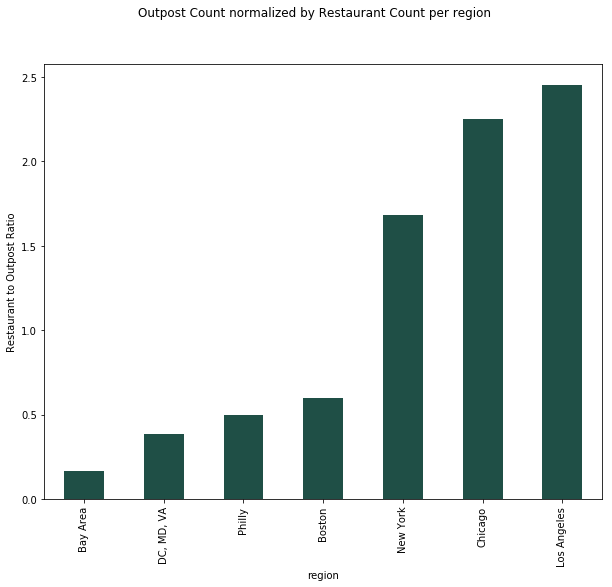

In [7]:
fig, ax = plt.subplots(figsize = (10,8))
(region_count_pivot["Outpost"] / region_count_pivot["Restaurant"]).sort_values().plot(kind="Bar", ax=ax, color="#1f4f46")
ax.set_ylabel("Restaurant to Outpost Ratio")
fig.suptitle("Outpost Count normalized by Restaurant Count per region")

## Why is there only one outpost in the Bay Area?

Validatning that data is correct

In [8]:
restaurants_df[restaurants_df["region"] == "Bay Area"][["region", "address", "city", "state", "restaurant_slug", "hidden", "is_outpost", "name"]]

,region,address,city,state,restaurant_slug,hidden,is_outpost,name
41,Bay Area,1890 Shattuck Ave,Berkeley,CA,berkeley,False,False,Berkeley
44,Bay Area,581 Ramona St,Palo Alto,CA,palo-alto,False,False,Palo Alto
55,Bay Area,171 2nd St,San Francisco,CA,soma,False,False,Soma
66,Bay Area,440 Castro St,Mountain View,CA,mountain-view,False,False,Mountain View
75,Bay Area,300 W El Camino Real,Sunnyvale,CA,sunnyvale,False,False,Sunnyvale
87,Bay Area,1 East 3rd Ave,San Mateo,CA,san-mateo,False,False,San Mateo
144,Bay Area,Three Embarcadero Center,San Francisco,CA,pwc-sf,False,True,sg Outpost at PwC SF
